In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from matplotlib import patches

from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, skewtest, kurtosis
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches

import sys, warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [3]:
dir = './FULLSET/'
f1 = sorted(glob.glob(dir+'knb-lter_*meters.csv'))

month = [x for x in range(1,13)]
loco_t = np.empty([len(f1),len(month),25])
loco_q = np.empty([len(f1),len(month),25])
loco_t[:] = np.nan
loco_q[:] = np.nan

for ff,f in enumerate(f1):
    print(f)
    df = pd.read_csv(f, sep=',')
    
    for mm,m in enumerate(month):
        val6 = df["ME_MEAN"][(df['month']==m)]
        val7 = df["TE_MEAN"][(df['month']==m)]
    
        if val6.notnull().sum() ==25:
            loco_q[ff,mm,:] = val6
        del val6
        if val7.notnull().sum() ==25:
            loco_t[ff,mm,:] = val7
        del val7
        
    del df


./FULLSET/knb-lter_1.5meters.csv
./FULLSET/knb-lter_56.0meters.csv


In [4]:
season = ["MJJAS"]
season_mon = np.array([[4,5,6,7,8]])

In [5]:
import metpy.calc as mpcalc
from metpy.units import units

xlim1 = 15298.653349999999 
xlim2 = 20792.86845
ylim1 = 280062.5663
ylim2 = 298744.1237
num = 3000
endpoint = True

xar1 = np.linspace(xlim1, xlim2, num, endpoint)
yar1 = np.linspace(ylim1, ylim2, num, endpoint)
xar = xar1 / 2.5e+6
yar = yar1 / 1005. / ( ( 100./101.325 ) ** (0.286) )

pa = [1013.25] * units.hPa
ta = yar * units.kelvin
q  = xar * units('kg/kg')

rhs = np.linspace(40, 100, 7, endpoint)
rh_range = mpcalc.relative_humidity_from_specific_humidity(pa,np.flip(ta),q).to('percent')

far = np.empty([7,num]) # temperature
far[:] = np.nan

for x, xx in enumerate(q):
    rh1 = mpcalc.relative_humidity_from_specific_humidity(pa,ta,xx).to('percent')
    for l, rh in enumerate(rhs):
        a,b = find_nearest(rh1,rh)
        far[l,x] = 1005. * yar[a] * ( 100./101.325 ) ** (0.286)

279455.5246965889 299662.62841444806
15023.942594999999 21067.579205000002


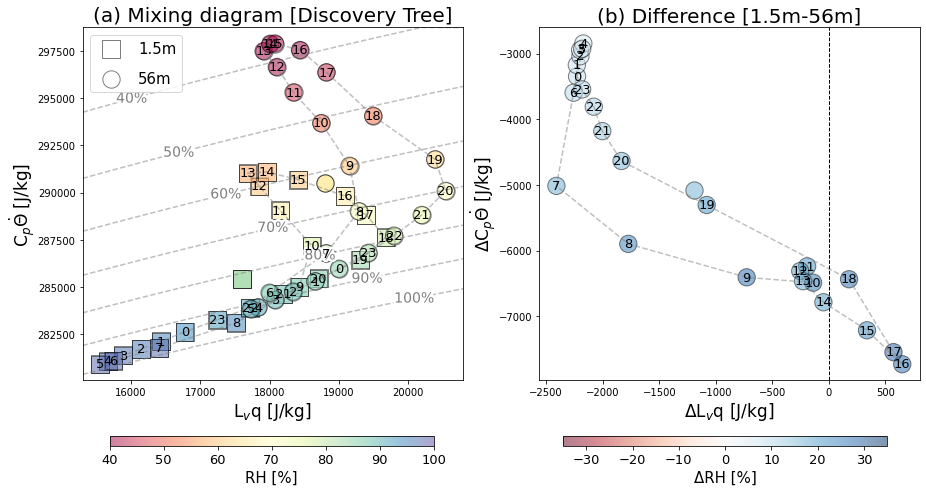

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches
from labellines import labelLine, labelLines

sea = 0
s = season_mon[sea]

xylab = ['L$_v$q [J/kg]', r'C$_p$$\dot{\Theta}$ [J/kg]']
lst = [x for x in range(24)]


fname="./knb-lter_mixing_diag.png"
subtitle = ['(a) Mixing diagram [Discovery Tree]','(b) Difference [1.5m-56m]']

fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(121)
x1, y1 = np.nanmean(loco_q[0,s,1:],axis=0), np.nanmean(loco_t[0,s,1:],axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)
z1, v1 = np.nanmean(loco_q[1,s,1:],axis=0), np.nanmean(loco_t[1,s,1:],axis=0)
zz2, vv2 = np.nanmean(z1), np.nanmean(v1)

xar = x1 / 2.5e+6
yar = y1 / 1005. / ( ( 100./101.325 ) ** (0.286) )
pa = [1013.25] * units.hPa
ta = yar * units.kelvin
q  = xar * units('kg/kg')
c1 = mpcalc.relative_humidity_from_specific_humidity(pa,ta,q).to('percent')

xar = z1 / 2.5e+6
yar = v1 / 1005. / ( ( 100./101.325 ) ** (0.286) )
pa = [1013.25] * units.hPa
ta = yar * units.kelvin
q  = xar * units('kg/kg')
d1 = mpcalc.relative_humidity_from_specific_humidity(pa,ta,q).to('percent')

cc2 = np.nanmean(c1)
dd2 = np.nanmean(d1)

ax.plot(xar1,far[0,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='40%')
ax.plot(xar1,far[1,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='50%')
ax.plot(xar1,far[2,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='60%')
ax.plot(xar1,far[3,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='70%')
ax.plot(xar1,far[4,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='80%')
ax.plot(xar1,far[5,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='90%')
ax.plot(xar1,far[6,:],color='gray',linestyle='--',linewidth=1.5,alpha=0.5,label='100%')
labelLines(ax.get_lines(), align=False, fontsize=14)

ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([x1[len(x1)-1], x1[0]],[y1[len(y1)-1], y1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
lm1 = ax.scatter(x1, y1, s=300, marker='s', facecolors='white', edgecolors='black', alpha=0.5, vmin=40, vmax=100)
im1 = ax.scatter(x1, y1, c=c1, cmap='Spectral', s=300, marker='s', edgecolors='black', alpha=0.5, vmin=40, vmax=100)

ax.plot(z1,v1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([z1[len(x1)-1], z1[0]],[v1[len(y1)-1], v1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
lm2 = ax.scatter(z1, v1, s=300, marker='o', facecolors='white', edgecolors='black', alpha=0.5, vmin=40, vmax=100)
im2 = ax.scatter(z1, v1, c=d1, cmap='Spectral', s=300, marker='o', edgecolors='black', alpha=0.5, vmin=40, vmax=100)

ax.scatter(xx2, yy2, c=cc2, cmap='Spectral', s=300, marker='s', edgecolors='black', alpha=0.8, vmin=40, vmax=100)
ax.scatter(zz2, vv2, c=dd2, cmap='Spectral', s=300, marker='o', edgecolors='black', alpha=0.8, vmin=40, vmax=100)



for i, txt in enumerate(lst):
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

for i, txt in enumerate(lst):
    ax.annotate(i, xy=(z1[i], v1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

# ax.tick_params(labelsize=15)
ax.set_xlabel(xylab[0], labelpad = 3,fontsize=17)
ax.set_ylabel(xylab[1], labelpad = 1,fontsize=17)
ax.set_title('{}'.format(subtitle[0]),fontsize=20)     

ax.legend([lm1, lm2],['1.5m','56m'],fontsize=15,loc='upper left',labelcolor='black', labelspacing=1.0, columnspacing=1.0)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()

print(y_min, y_max)
print(x_min, x_max)
ax.set_xlim([xlim1, xlim2])
ax.set_ylim([ylim1, ylim2])

# fig.subplots_adjust(right=0.94)
# cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
# cb = fig.colorbar(im1, cax=cbar_ax)
fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.05, 0.3, 0.02])
cb = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cb.set_label(label='RH [%]', size=15)
cb.ax.tick_params(labelsize=13)

ax = fig.add_subplot(122)
x1, y1, z1 = np.nanmean(loco_q[0,s,1:],axis=0)-np.nanmean(loco_q[1,s,1:],axis=0), np.nanmean(loco_t[0,s,1:],axis=0)-np.nanmean(loco_t[1,s,1:],axis=0), c1-d1
xx2, yy2, zz2 = np.nanmean(x1), np.nanmean(y1), np.nanmean(z1)

ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([x1[len(x1)-1], x1[0]],[y1[len(y1)-1], y1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
im3 = ax.scatter(x1, y1, c=z1, cmap='RdBu', s=300, marker='o', edgecolors='black', alpha=0.5, vmin=-35, vmax=35)

ax.scatter(xx2, yy2, c=zz2, cmap='RdBu', s=300, marker='o', edgecolors='black', alpha=0.5, vmin=-35, vmax=35)
# ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

for i, txt in enumerate(lst):
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

# ax.tick_params(labelsize=15)
ax.set_xlabel("Δ{}".format(xylab[0]), labelpad = 3,fontsize=17)
ax.set_ylabel("Δ{}".format(xylab[1]), labelpad = 1,fontsize=17)
ax.set_title('{}'.format(subtitle[1]),fontsize=20)      

# fig.subplots_adjust(right=0.94)
# cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
# cb = fig.colorbar(im1, cax=cbar_ax)
fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.57, 0.05, 0.3, 0.02])
cb = fig.colorbar(im3, cax=cbar_ax, orientation='horizontal')
cb.set_label(label='ΔRH [%]', size=15)
cb.ax.tick_params(labelsize=13)

# fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()